Dropout[1] - метод регуляризации нейронных сетей путем случайной установки некоторых признаков в ноль во время прямого распространения. В этом задании необходимо реализовать слой Dropout и модифицировать полносвязанный класс, чтобы, при необходимости, использовать Dropout.

[1] [Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012](https://arxiv.org/abs/1207.0580)

In [3]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Dropout: прямой путь
В файле `cs231n / layers.py`, реализуйте прямое распространение для Dropout. Поскольку Dropout ведет себя по-разному во время обучения и тестирования, обязательно выполните операцию для обоих режимов.

Затем запустите ячейку ниже, чтобы проверить реализацию (возможно Вам повезло и код уже реализован).

In [5]:
np.random.seed(231)
x = np.random.randn(500, 500) + 10

for p in [0.25, 0.4, 0.7]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
  print()

Running tests with p =  0.25
Mean of input:  10.000207878477502
Mean of train-time output:  10.014059116977283
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.749784
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.4
Mean of input:  10.000207878477502
Mean of train-time output:  9.977917658761159
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.600796
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.7
Mean of input:  10.000207878477502
Mean of train-time output:  9.987811912159426
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.30074
Fraction of test-time output set to zero:  0.0



# Dropout : обратный путь
В файле `cs231n / layers.py`, реализуйте обратный путь для Dropout. После этого запустите код ниже для проверки градиента.

In [6]:
np.random.seed(231)
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.2, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

# Error should be around e-10 or less
print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.44560814873387e-11


## Вопрос 1:
Что произойдет, если мы не разделим значения, передаваемые по обратному пути  на `p` ? 

## Ответ:

Иначе мы будем считать, что выход слоя будет px вместо x, поэтому что мы умножаем его на  1 / p.

# Полносвязанные сети с Dropout
В файле `cs231n / classifiers / fc_net.py` измените  реализацию, чтобы использовать Dropout. Если конструктор сети получает значение, не равное 1 для параметра `dropout`, то сеть должна добавить dropout сразу после каждой нелинейности ReLU. После этого выполните проверку градиента ниже в ячейке.

In [7]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [1, 0.75, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Relative errors should be around e-6 or less; Note that it's fine
  # if for dropout=1 you have W2 error be on the order of e-5.
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  print()

Running check with dropout =  1
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11

Running check with dropout =  0.75
Initial loss:  2.3032347226387464
W1 relative error: 6.46e-08
W2 relative error: 2.92e-07
W3 relative error: 2.09e-08
b1 relative error: 1.23e-08
b2 relative error: 1.59e-09
b3 relative error: 9.52e-11

Running check with dropout =  0.5
Initial loss:  2.303349343266342
W1 relative error: 1.10e-08
W2 relative error: 1.92e-08
W3 relative error: 3.14e-08
b1 relative error: 5.52e-09
b2 relative error: 3.32e-09
b3 relative error: 1.40e-10



# Эксперимент с регуляризацией
В качестве эксперимента обучим 2 двухслойные сети на 500 примерах: одна из них не будет использовать dropout, а другая будет использовать с вероятность сохранения активности 0,25. Затем визуализируем зависимости точности обучения и валидации двух сетей с течением времени.

In [8]:
# Train two identical nets, one with dropout and one without
np.random.seed(231)
num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [1, 0.25]
for dropout in dropout_choices:
  model = FullyConnectedNet([500], dropout=dropout)
  print(dropout)

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver

1
(Iteration 1 / 125) loss: 7.856643
(Epoch 0 / 25) train acc: 0.260000; val_acc: 0.184000
(Epoch 1 / 25) train acc: 0.414000; val_acc: 0.261000
(Epoch 2 / 25) train acc: 0.482000; val_acc: 0.278000
(Epoch 3 / 25) train acc: 0.538000; val_acc: 0.274000
(Epoch 4 / 25) train acc: 0.604000; val_acc: 0.266000
(Epoch 5 / 25) train acc: 0.740000; val_acc: 0.301000
(Epoch 6 / 25) train acc: 0.738000; val_acc: 0.287000
(Epoch 7 / 25) train acc: 0.832000; val_acc: 0.261000
(Epoch 8 / 25) train acc: 0.856000; val_acc: 0.270000
(Epoch 9 / 25) train acc: 0.896000; val_acc: 0.282000
(Epoch 10 / 25) train acc: 0.922000; val_acc: 0.267000
(Epoch 11 / 25) train acc: 0.926000; val_acc: 0.271000
(Epoch 12 / 25) train acc: 0.944000; val_acc: 0.299000
(Epoch 13 / 25) train acc: 0.964000; val_acc: 0.299000
(Epoch 14 / 25) train acc: 0.982000; val_acc: 0.300000
(Epoch 15 / 25) train acc: 0.980000; val_acc: 0.287000
(Epoch 16 / 25) train acc: 0.976000; val_acc: 0.296000
(Epoch 17 / 25) train acc: 0.972000; v

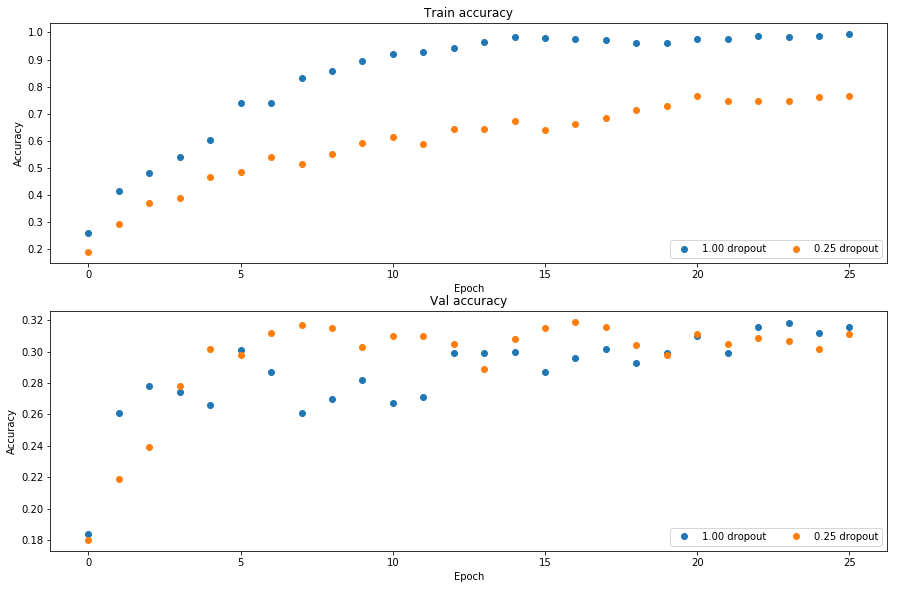

In [9]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Вопрос 2:
Сравните точность валидации и обучения с dropout и без. Как соотносится dropout и регуляризация, что  говорят об этом результаты Вашего эксперимента?

## Ответ:

Без использования dropout окончательная разница между точностью обучения (99%) и точностью проверки (29%) составляет около 70%. После использования dropout с p = 0,75, окончательная разница между точностью обучения (92%) и точностью проверки (31%) составляет около 61%. Мы видим, что разница между train и valiation была уменьшена. Таким образом, это предполагает, что dropout может решить проблему переобучения.

## Вопрос 3:
Предположим, что мы обучаем глубокую полносвязанную сеть для классификации изображений, с dropout после скрытых слоев (параметризуемую вероятностью сохранения активности p). Как нам изменить p,  если мы решим уменьшить размер скрытых слоев (т. е. количество узлов в каждом слое)?

## Ответ:
Установить в 0.5

Если идея dropout заключается в том, чтобы эффективно обучить множество подсетей в сети, чтобы  сеть действовала как сумма множества небольших сетей, тогда 50% (p=0.5) привело бы к равному распределению вероятностей для каждой возможной подсети, которую можно создать, выбрасывая нейроны.